# ISIC 2018 - Task 1 - Attempt 1

In [22]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting

%reload_ext autoreload
%autoreload 2
%matplotlib inline

Using fastai lib

In [23]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import time
from sklearn.model_selection import StratifiedKFold

In [3]:
# Uncomment the below if you need to reset your precomputed activations
!rm -rf {PATH}tmp

Set model parameters:

## Data

In [40]:
PATH = Path("Task3/")
SZ = 224 #resnet restriction
ARCH = resnet50
BS = 64
TFMS = tfms_from_model(ARCH, 
                       SZ, 
                       aug_tfms=None
                      )
GT_FN = "Training_GT/Task3_Training_GT.csv"
GT = pd.read_csv(PATH/GT_FN)


In [25]:
len(GT), GT.head(10)

(10015,           image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
 0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
 1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
 2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
 3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
 4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
 5  ISIC_0024311  0.0  1.0  0.0    0.0  0.0  0.0   0.0
 6  ISIC_0024312  0.0  0.0  0.0    0.0  1.0  0.0   0.0
 7  ISIC_0024313  1.0  0.0  0.0    0.0  0.0  0.0   0.0
 8  ISIC_0024314  0.0  1.0  0.0    0.0  0.0  0.0   0.0
 9  ISIC_0024315  1.0  0.0  0.0    0.0  0.0  0.0   0.0)

### Check Data

In Excel, already checked that every row sums to 1.

In [26]:
IMAGE, MEL, NV, BCC, AKIEC, BKL, DF, VASC = "image", "MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"

In [27]:
labels = list(GT)
labels.remove(IMAGE)
GT[labels].head(10)

,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
labels

['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

In [29]:
y_labels = list(GT[labels].idxmax(axis=1))
y_labels[:10], len(y_labels)

(['NV', 'NV', 'NV', 'NV', 'MEL', 'NV', 'BKL', 'MEL', 'NV', 'MEL'], 10015)

In [30]:
x_fnames = list(GT[IMAGE])
len(x_fnames)

10015

In [31]:
y_labels[:10],len(y_labels)

(['NV', 'NV', 'NV', 'NV', 'MEL', 'NV', 'BKL', 'MEL', 'NV', 'MEL'], 10015)

In [32]:
dummy = pd.DataFrame(
    {'filename': x_fnames,
     'category': y_labels
    })
dummy.head(10)

,filename,category
0,ISIC_0024306,NV
1,ISIC_0024307,NV
2,ISIC_0024308,NV
3,ISIC_0024309,NV
4,ISIC_0024310,MEL
5,ISIC_0024311,NV
6,ISIC_0024312,BKL
7,ISIC_0024313,MEL
8,ISIC_0024314,NV
9,ISIC_0024315,MEL


In [33]:
list(PATH.iterdir())

[PosixPath('Task3/.DS_Store'),
 PosixPath('Task3/Training_GT'),
 PosixPath('Task3/Training_Input')]

In [34]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/fastai_formatted.csv'

In [35]:
dummy.to_csv(CSV, index=False)

In [37]:
IMGS_DIR = 'Training_Input'

In [72]:
md = ImageClassifierData.from_csv(PATH, IMGS_DIR, CSV, tfms=TFMS, bs=BS, suffix=".jpg")


In [73]:
md.trn_y[:10]

array([5, 5, 4, 5, 2, 4, 4, 5, 5, 5])

In [74]:
md.classes

['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

In [75]:
len(md.trn_ds.fnames), len(md.val_ds.fnames)

(8012, 2003)

In [76]:
md.trn_ds.fnames[1011], md.trn_y[1011]

('Training_Input/ISIC_0025584.jpg', 1)

Loaded with right label

In [114]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_axis_off()
    return ax

In [110]:
def sample(dataloader, data):
    x, y = next(iter(dataloader))
    x = to_np(x)
    y = to_np(y)
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i,ax in enumerate(axes.flat):
        image=data.trn_ds.denorm(x)[i]
        label= data.classes[y[i]]
        fname = data.trn_ds.fnames[i].split('/')[-1].split('.')[0]
        ax = show_img(image, ax=ax)
        ax.set_title('{} ({})'.format(fname, label))
    plt.tight_layout()

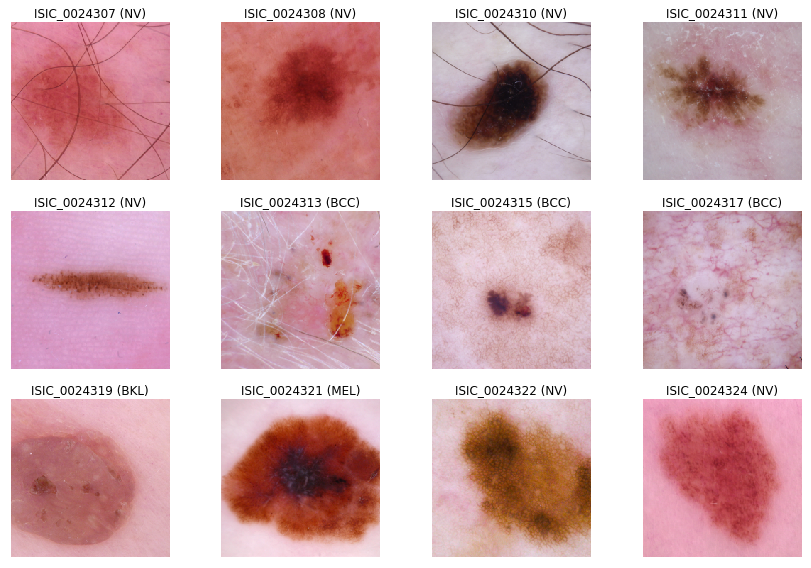

In [115]:
sample(md.trn_dl, md)

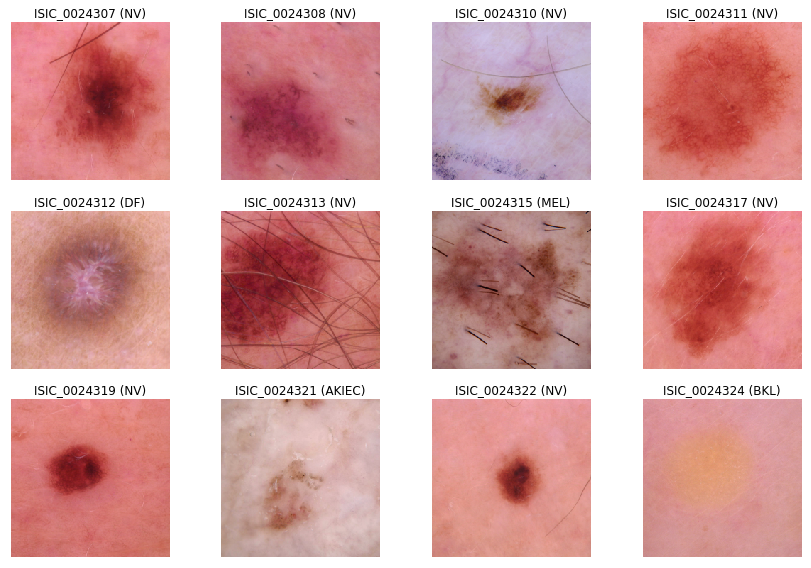

In [116]:
sample(md.val_dl, md)

In [118]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomDihedral(tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]
TFMS = tfms_from_model(ARCH, 
                       SZ, 
                       aug_tfms=aug_tfms
                      )

In [119]:
md = ImageClassifierData.from_csv(PATH, IMGS_DIR, CSV, tfms=TFMS, bs=BS, suffix=".jpg")

## Model Training

In [133]:
learn = ConvLearner.pretrained(ARCH, md, precompute=False)

In [132]:
learn.lr_find(1e-5,100)

  0%|          | 0/126 [00:00<?, ?it/s]


ValueError: Axes=(0, 1) out of range for array of ndim=0.

  0%|          | 0/126 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected at least 2, got 0)

In [57]:
def kFold(k, X, Y):
  skf = StratifiedKFold(n_splits=k)
  i =0
  # data = []
  index = []
  for train_index, val_index in skf.split(X, Y):
      index.append((train_index, val_index))
      # X_train = X[train_index]
      # Y_train = Y[train_index]
      # X_valid = X[val_index]
      # Y_valid = Y[val_index]
      # trn = (X_train, Y_train)
      # val = (X_valid, Y_valid)
      # data.append(ImageClassifierData.from_arrays(path=PATH, bs=4,trn=trn, val=val, tfms=TFMS, test=(tst, tst_ctg)))
      i+=1
  # return data, index
  return index